In [83]:
from skimage import measure, io, draw
from skimage.future import graph

import json
from pprint import pprint
import numpy as np
import pandas as pd
from pyemd import emd_samples

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

np.random.seed(0)

# Data Processing

In [ ]:
# Load the data in as a Pandas DataFrame
df = pd.read_pickle('./data/20200423-1804_states_timestep_mod_25.pickle')
print(f'Length of df: {len(df)}')

We will use a data set containing 4 versions (i.e., different random initial values) of trajectories generated with parameters $BR \in \{ 0.50, 0.53, 0.56, 0.59\}$ and $CHI \in \{ 2.2, 2.8, 3.4, 4.0 \}$ for a total of 64 trajectories, each containing a number of morphologies.

Since many of the morphology samples look very similar, we'll only keep the first and every 25th morphology (i.e., when `timestep % 25 == 0`) of each trajectory.  This will reduce processing time and make the visualizations easier to interpret.

In [ ]:
print('Unique BR values:', np.unique(df.BR))
print('Unique CHI values:', np.unique(df.CHI))
print('Unique version values:', np.unique(df.version))
print('Total Trajectories:', len(df.groupby(['BR', 'CHI', 'version'])))
print('Total Morphologies:', len(df))

In [ ]:
# Print a sample record
sample = df.iloc[206] # grab random sample
print(sample) # print the sample record

We can vizualize the data as a Heatmap with Plotly.  This function generates a template figure and it's layout to be used with our data.

In [ ]:
def get_sample_fig(data=None, height=75, width=300, margin=0):
    if height is None:
        height = data.shape[0]
    if width is None:
        width = data.shape[1]
    if height < 10:
        height = 10
    if width < 10:
        width = 10
        
    if margin is None:
        # default
        margin = dict(l=20, r=20, t=5, b=5)
    if type(margin) == int:
        margin = dict(l=margin, r=margin, t=margin, b=margin)
    
    # Generate Layout
    sample_fig_layout = go.Layout(
            height=height,
            width=width,
            showlegend=False,
            margin=margin,
            xaxis={
                'showgrid': False,
                'zeroline': False,
                'visible': False
            },
            yaxis={
                'showgrid': False,
                'zeroline': False,
                'visible': False
            },
        )
    
    # Generate Fig
    sample_fig = go.FigureWidget(
        data=go.Heatmap(
            z=data,
            hoverinfo='none',
            showscale=False
        ),
        layout=sample_fig_layout
    )
    return sample_fig

In [ ]:
sample_image = sample.image.reshape((100, 400))
fig = get_sample_fig(sample_image)
fig

## Components

We want to isolate each component for individual analysis.  We can do so with `scikit.measure.label`.  Notice that we're ignoring one of the materials (the yellow material in the above visualization).

In [ ]:
# extract each labeled segment to it's own frame
def extract_components(sample_image):
    components = []
    sample_image = (sample_image > 0.5).astype(int) # binarize
    labeled_sample = measure.label(sample_image, background=-1)
    for idx, label in enumerate(np.unique(labeled_sample)):
        component = (
            # we only want the component matching our current label
            # and whose pixel value is '0'
            (labeled_sample == label) & (sample_image == 0)
        ).astype(np.float64)
        if not (component == 0).all():
            # if the entire image isn't all blank, collect it
            components.append(component)
    return components

In [ ]:
components = extract_components(sample_image)

print('Original')
display(get_sample_fig(sample_image))

for idx, component in enumerate(components):
    if idx % 25 == 0:
        print(f'Component {idx}')
        display(get_sample_fig(component))
    if idx > 100:
        break

Cropping the components will be useful for our analysis.

In [ ]:
def crop_image(img, tol=0):
    mask = img > tol
    return img[np.ix_(mask.any(1),mask.any(0))]

for idx, component in enumerate(components):
    if idx % 25 == 0:
        print(f'Cropped Component {idx}')
        display(get_sample_fig(crop_image(component), width=None, height=None))
    if idx > 100:
        break

# Earth Mover's Distance

Introduced in the paper ["A Metric for Distributions with Applications to Image Databases"](https://users.cs.duke.edu/~tomasi/papers/rubner/rubnerIccv98.pdf), 1998 (Rubner, Tomasi, and Guibas), the Earth Mover's Distance (EMD) is a metric which can be used to determine the similarity between two distributions.

EMD has many applications, including image database retrieval and GAN training.  A nice, brief explanation can be [found here](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html#what-is-wasserstein-distance), and a more thorough write-up can be [found here](http://infolab.stanford.edu/pub/cstr/reports/cs/tr/99/1620/CS-TR-99-1620.ch4.pdf).

Consider the following example where three normal distributions (two with the same parameters) are sampled and compared using EMD:

In [ ]:
dist1 = [np.random.normal(0.0, 1.0) for _ in range(1000)]
dist2 = [np.random.normal(0.0, 1.0) for _ in range(1000)]
dist3 = [np.random.normal(0.0, 0.5) for _ in range(1000)]

dists = [dist1, dist2, dist3]

So,

$$dist_1 \sim \mathcal{N}(0, 1)$$
$$dist_2 \sim \mathcal{N}(0, 1)$$
$$dist_3 \sim \mathcal{N}(0, 0.5)$$

which we can vizualize below:

In [ ]:
fig = make_subplots(rows=1, cols=3)

for idx, dist in enumerate(dists):
    fig.add_histogram(
        x=dist,
        row=1,
        col=idx+1
    )
    fig.update_xaxes(title_text=f'dist{idx+1}', range=[-3, 3], row=1, col=idx+1)

fig.update_layout(showlegend=False)
fig.show()

Now, if we we're to use EMD to compare the similarity between these three distributions, we would expect $EMD(dist_1, dist_2) << EMD(dist_2, dist_3) \approx EMD(dist_3, dist_1)$.

[PyEMD](https://pypi.org/project/pyemd/) provides an effecient implementation of the Earth Mover's Distance.

In [ ]:
print(f'EMD(dist1, dist2) = {emd_samples(dist1, dist2)}')
print(f'EMD(dist2, dist3) = {emd_samples(dist2, dist3)}')
print(f'EMD(dist3, dist1) = {emd_samples(dist3, dist1)}')

Here's a slightly more complex example where our samples are 2-dimensional.

In [77]:
d1 = [(
    np.random.normal(0.0, 0.2),
    np.random.normal(0.0, 0.2)
) for _ in range(80)]

d2 = [(
    np.random.normal(0.0, 0.2),
    np.random.normal(0.0, 0.2)
) for _ in range(110)]

d3 = [(
    np.random.normal(0.0, 0.2),
    np.random.normal(0.2, 0.0)
) for _ in range(100)]

d4 = [(
    np.random.normal(0.2, 0.2),
    np.random.normal(0.2, 0.2)
) for _ in range(100)]

dists = [d1, d2, d3, d4]

In [78]:
print(f'EMD(dist1, dist2) = {emd_samples(d1, d2)}')
print(f'EMD(dist2, dist3) = {emd_samples(d2, d3)}')
print(f'EMD(dist3, dist4) = {emd_samples(d3, d4)}')
print(f'EMD(dist4, dist1) = {emd_samples(d4, d1)}')

EMD(dist1, dist2) = 0.028076527401698192
EMD(dist2, dist3) = 0.13787924336631607
EMD(dist3, dist4) = 0.1102165014220171
EMD(dist4, dist1) = 0.22253389647039082


To better visualize the distance between our distributions, we can construct a distance matrix visualization.

In [79]:
def get_dist_matrix(sigs_x, sigs_y=None):
    if sigs_y is None:
        sigs_y = sigs_x
    elif type(sigs_y[0]) != list:
        sigs_y = [sigs_y]*len(sigs_x)
    dist_matrix = []
    for y in sigs_y:
        row = []
        for x in sigs_x:
            row.append(emd_samples(x, y))
        dist_matrix.append(row)
    return dist_matrix

def get_dist_fig(dist_matrix, labels_x=None, labels_y=None):
    dist_fig = go.FigureWidget(
        data=go.Heatmap(
            x=labels_x,
            y=labels_y,
            z=dist_matrix
        ),
        layout=go.Layout(
            coloraxis_showscale=False,
            height=600,
            width=600,
            #margin=dict(b=90, t=90, l=96, r=0),
            xaxis=dict(
                autorange=True,
                showgrid=False,
                ticks='',
                showticklabels=False
            ),
            yaxis=dict(
                scaleanchor='x',
                autorange=True,
                showgrid=False,
                ticks='',
                showticklabels=False
            )
        )
    )
    return dist_fig

In [80]:
get_dist_fig(get_dist_matrix(dists))

FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': 'ef15f6f8-c558-4ba1-bd1f-1bcdba2e8686',
 …

# EMD on Images

We need to extract the signature of each image.  We do so with a function which accepts an array of images and a function which extracts the signature for each image.

In [90]:
def get_signatures(images, sig_funcs):
    if type(sig_funcs) != list:
        sig_funcs = [sig_funcs]
    sigs = []
    for image in images:
        image_sigs = []
        for sig_func in sig_funcs:
            sig = sig_func(image)
            if len(sig) > 0:
                image_sigs.append(sig)
            else:
                image_sigs.append([0.]) # need to add dummy data for now
        sigs.append(np.array(image_sigs).T.tolist())
    return sigs

# Use some signature for demonstration
def extract_pixel_color_ratio_signature(image):
    ratios = []
    components = extract_components(image)
    for idx, component in enumerate(components):
        ratio = np.sum(component == 1)/np.sum(component == 0)
        ratios.append(ratio)
    return ratios

In [91]:
str(get_signatures(
    df.iloc[:10].image.apply(lambda image: image.reshape((100, 400))),
    extract_pixel_color_ratio_signature
))[:100] + '...'

'[[[0.0]], [[0.0008006405124099279], [0.004671723514341689], [0.0006754559327546094], [0.009998990001...'

We can use Plotly to build interactive widgets to better visualize our data.

In [92]:
def get_dist_widget(dist_matrix, df_x, df_y=None):
    # Accepts a distance matrix and DataFrames df_x and df_y
    # corresponding to the x and y components of the matrix.
    
    # If df_y is None, it is assumed to be the same as df_x.
    if df_y is None:
        df_y = df_x
        
    # These are the hover labels
    labels_x = [
        json.dumps(dict(row[['BR', 'CHI', 'version', 'timestep']]))
        for idx, row in df_x.iterrows()
    ]
    labels_y = [
        json.dumps(dict(row[['BR', 'CHI', 'version', 'timestep']]))
        for idx, row in df_y.iterrows()
    ]
    dist_fig = get_dist_fig(
        dist_matrix,
        labels_x=labels_x,
        labels_y=labels_y
    )
    
    # The stand-in morphology visualizations.
    sample_fig_x = get_sample_fig(margin=None)
    sample_fig_y = get_sample_fig(margin=None)
    
    # Prints the morphology information.
    out_x = widgets.Output()
    out_y = widgets.Output()
    
    # This gets triggered when the Heatmap is clicked on.
    def show_samples(trace, points, selector):
        # Get the params from the clicked cell
        x_params = pd.Series(json.loads(points.xs[0]))
        # Find it in the DataFrame
        sample_x = df_x[(df_x[['BR', 'CHI', 'version', 'timestep']] == x_params).all(1)].iloc[0]
        # Set the morphology viz to this image
        sample_fig_x.data[0].z = sample_x.image.reshape((100, 400))
        # Clear the output, then print the morph. info to it
        out_x.clear_output()
        with out_x:
            print("Sample:")
            print(sample_x[['BR', 'CHI', 'version', 'timestep']])

        # Do the same as above, but for the y-datapoint.
        y_params = pd.Series(json.loads(points.ys[0]))
        sample_y = df_y[(df_y[['BR', 'CHI', 'version', 'timestep']] == y_params).all(1)].iloc[0]
        sample_fig_y.data[0].z = sample_y.image.reshape((100, 400))
        out_y.clear_output()
        with out_y:
            print("Sample:")
            print(sample_y[['BR', 'CHI', 'version', 'timestep']])

    # Set the click callback on the distance Heatmap to the above function
    dist_fig.data[0].on_click(show_samples)

    # We use VBox and HBox to structure the visualizations
    return widgets.VBox([
        dist_fig,
        widgets.HBox([
            widgets.VBox([
                sample_fig_x,
                out_x
            ], layout={'max_width': '300px'}),
            widgets.VBox([
                sample_fig_y,
                out_y
            ], layout={'max_width': '300px'})
        ],
        layout=widgets.Layout(
            display='flex',
            justify_content='center'
        ))
    ])

def build_dist_widget(sig_funcs, indices_x, indices_y=None):
    # This builds the distance widget using the given indices
    if indices_y is None:
        indices_y = indices_x
    elif type(indices_y) != list:
        indices_y = [indices_y]*len(indices_x)

    sigs_x = get_signatures(
        df.iloc[indices_x].image.apply(lambda image: image.reshape((100, 400))),
        sig_funcs
    )
    sigs_y = get_signatures(
        df.iloc[indices_y].image.apply(lambda image: image.reshape((100, 400))),
        sig_funcs
    )
    
    dist_matrix = get_dist_matrix(sigs_x, sigs_y)
    
    return get_dist_widget(
        dist_matrix,
        df.iloc[indices_x],
        df.iloc[indices_y]
    )

def compare_trajs_widget(sig_funcs, traj_x, traj_y=None):
    # This builds the distance widget using the given trajectory params
    if traj_y is None:
        traj_y = traj_x
    indices_x = sorted(df[
        (df.BR == traj_x['BR']) &
        (df.CHI == traj_x['CHI']) &
        (df.version == traj_x['version'])
    ].index)
    indices_y = sorted(df[
        (df.BR == traj_y['BR']) &
        (df.CHI == traj_y['CHI']) &
        (df.version == traj_y['version'])
    ].index)
    return build_dist_widget(sig_funcs, indices_x, indices_y)

To test our visualizations, we pick a random trajectory and build a distance matrix widget comparing it's morphologies with themselves over time:

In [93]:
traj_x = { 'BR': 0.53, 'CHI': 3.4, 'version': 1 }

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Trajectory</h1>
        <h2>{traj_x}</h2>
    </div>
    '''),
    compare_trajs_widget(extract_pixel_color_ratio_signature, traj_x)
], layout=widgets.Layout(
    width='600px'
))

The visualization should produce a symmetric distance matrix with values of $0$ along the diagonal (since we're comparing the trajectory against itself).  We can click on cells in the Heatmap to see the corresponding images.

Next, we'll compare our trajectory to a different trajectory generated with the same parameters (i.e., two different versions):

In [94]:
# visualize two trajectories with the same parameters
traj_x = { 'BR': 0.53, 'CHI': 3.4, 'version': 1 }
traj_y = { 'BR': 0.53, 'CHI': 3.4, 'version': 2 }

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Trajectories</h1>
        <h2>{traj_x}<br>{traj_y}</h2>
    </div>
    '''),
    compare_trajs_widget(extract_pixel_color_ratio_signature, traj_x, traj_y)
], layout=widgets.Layout(
    width='600px'
))

Finally, we'll compare two trajectories with different parameters.

In [95]:
# visualize two trajectories with the different parameters
traj_x = { 'BR': 0.53, 'CHI': 3.4, 'version': 1 }
traj_y = { 'BR': 0.56, 'CHI': 4.0, 'version': 1 }

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Trajectories</h1>
        <h2>{traj_x}<br>{traj_y}</h2>
    </div>
    '''),
    compare_trajs_widget(extract_pixel_color_ratio_signature, traj_x, traj_y)
], layout=widgets.Layout(
    width='600px'
))

Interestingly, there may be a pattern forming in the rough diagonal of minimum values.  Notice that, trivially, comparing a trajectory to itself results in a perfect diagonal of exactly `0` values.

When comparing the trajectory with a different version of itself, the minimum values increased from `0` and these values shifted away from the diagonal (towards the top/left).  Then, when comparing this trajectory with one with different parameters, the diagonal and it's values shifted even more.

It may be the case that, when comparing trajectories, this diagonal and it's values can hint it the underlying generation parameters.  To test this, we create a visualization similar to above, but well use parameters on the otherside of the parameter spectrum, i.e., before we chose values for `BR` and `CHI` greater than our given trajectory, this time we'll choose values less than that of the given trajectory.

In [96]:
# visualize two trajectories with the different parameters
traj_x = { 'BR': 0.53, 'CHI': 3.4, 'version': 1 }
traj_y = { 'BR': 0.5, 'CHI': 2.8, 'version': 0 }

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Trajectories</h1>
        <h2>{traj_x}<br>{traj_y}</h2>
    </div>
    '''),
    compare_trajs_widget(extract_pixel_color_ratio_signature, traj_x, traj_y)
], layout=widgets.Layout(
    width='600px'
))

We see that the diagonal, this time, has shifted to the bottom/right.  These artifacts will be dependent on the signatures (and may be reversed based on which trajectory is in the x-axis/y-axis).  But this matches are intuition for how the distance in trajectories over time will change based on the underlying generation parameters.

# Other Signatures

We can build our signatures with different functions, producing metrics which are sensitive to different features of our components:

In [51]:
def extract_pixel_color_ratio_signature(image):
    ratios = []
    components = extract_components(image)
    for idx, component in enumerate(components):
        ratio = np.sum(component == 1)/np.sum(component == 0)
        ratios.append(ratio)
    return ratios

def extract_bound_box_shape_ratio_signature(image):
    ratios = []
    components = extract_components(image)
    for idx, component in enumerate(components):
        shape = crop_image(component).shape
        ratios.append(shape[0]/shape[1])
    return ratios

def extract_cropped_color_ratio_signature(image):
    ratios = []
    components = extract_components(image)
    for idx, component in enumerate(components):
        component = crop_image(component)
        ratio = np.sum(component == 0)/(np.sum(component == 1) + 1e-5)
        ratios.append(ratio)
    return ratios

def extract_vol_to_surf_ratio_signature(image):
    ratios = []
    components = extract_components(image)
    for idx, component in enumerate(components):
        perimeter = measure.perimeter(component)
        area = np.sum(component == 1)
        ratio = perimeter/(area + 1e-5)
        ratio = min(ratio, 0.2) # for better color scales
        ratios.append(ratio)
    return ratios

sig_extractors = {
    'Pixel Color Ratio': extract_pixel_color_ratio_signature,
    'Bounding-Box Shape Ratio': extract_bound_box_shape_ratio_signature,
    'Cropped Pixel Color Ratio': extract_cropped_color_ratio_signature,
    'Volume-Surface Ratio': extract_vol_to_surf_ratio_signature
}

We can supply a list of signature extraction functions to build a multi-dimensional signature out of them.

In [137]:
# visualize two trajectories with the same parameters
traj_x = { 'BR': 0.53, 'CHI': 3.4, 'version': 1 }
traj_y = { 'BR': 0.53, 'CHI': 3.4, 'version': 2 }

sig_funcs = [
    extract_pixel_color_ratio_signature,
    extract_cropped_color_ratio_signature
]

In [140]:
widget = compare_trajs_widget(sig_funcs, traj_x, traj_y)
widget.children[0].data[0].update(zmin=0., zmax=0.65) # this adjusts the color scale

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Trajectories</h1>
        <h2>{traj_x}<br>{traj_y}</h2>
    </div>
    '''),
    widget
], layout=widgets.Layout(
    width='600px'
))

# Examine Final States

Another way we can visualize our data is to extract the last morphology for each trajectory and compare their pair-wise distances.

This will extract the indicies for the last available morphology for each trajectory.  Notice that the order that we're listing these indices is based on `BR`, then `CHI`, then `version`.

In [115]:
final_state_indices = []
for grouping, group in df.groupby(['BR', 'CHI', 'version']):
    if grouping[2] != 0:
        # Only use version 0 trajectories
        continue
    final_state = group[group.timestep == max(group.timestep)].iloc[0]
    final_state_indices.append(final_state.name)

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Final States</h1>
        <h2>Ordered by BR -> CHI -> version</h2>
    </div>
    '''),
    build_dist_widget(extract_pixel_color_ratio_signature, final_state_indices)
], layout=widgets.Layout(
    width='600px'
))

Notice the range of distances and the "hotspots" near `CHI` values of 2.8.

Another perspective is to create the same visualization, but ordering from `CHI` to `BR` instead:

In [116]:
final_state_indices = []
for grouping, group in df.groupby(['CHI', 'BR', 'version']):
    if grouping[2] != 0:
        # Only use version 0 trajectories
        continue
    final_state = group[group.timestep == max(group.timestep)].iloc[0]
    final_state_indices.append(final_state.name)

widgets.VBox([
    widgets.HTML(f'''
    <div style="text-align: center;">
        <h1>Final States</h1>
        <h2>Ordered by CHI -> BR -> version</h2>
    </div>
    '''),
    build_dist_widget(extract_pixel_color_ratio_signature, final_state_indices)
], layout=widgets.Layout(
    width='600px'
))

This visualization, along with last, indicates that this particular signature is more sensitive to changes in `CHI` values compared to changes in `BR` values.

# Compare One Sample to the Rest

In [177]:
print('BRs:', np.unique(df.BR))
print('CHIs:', np.unique(df.CHI))

BRs: [0.5  0.53 0.56 0.59]
CHIs: [2.2 2.8 3.4 4. ]


In [225]:
sample_traj = df[
    (df.BR == 0.56) &
    (df.CHI == 3.4) &
    (df.version == 0)
]
sample_state = sample_traj[sample_traj.timestep == max(sample_traj.timestep)].iloc[0]
sig_func = extract_pixel_color_ratio_signature

In [226]:
dist_matrix = []
for br, br_group in df.groupby(['BR']):
    dist_row = []
    for chi, chi_group in br_group.groupby(['CHI']):
        for version, traj in chi_group.groupby(['version']):
            if version != 0:
                # Only use version 0 trajectories
                continue
            final_state = traj[traj.timestep == max(traj.timestep)].iloc[0]
            dist_row.append(emd_samples(
                sig_func(final_state.image.reshape((100, 400))),
                sig_func(sample_state.image.reshape((100, 400)))
            ))
        dist_matrix.append(dist_row)

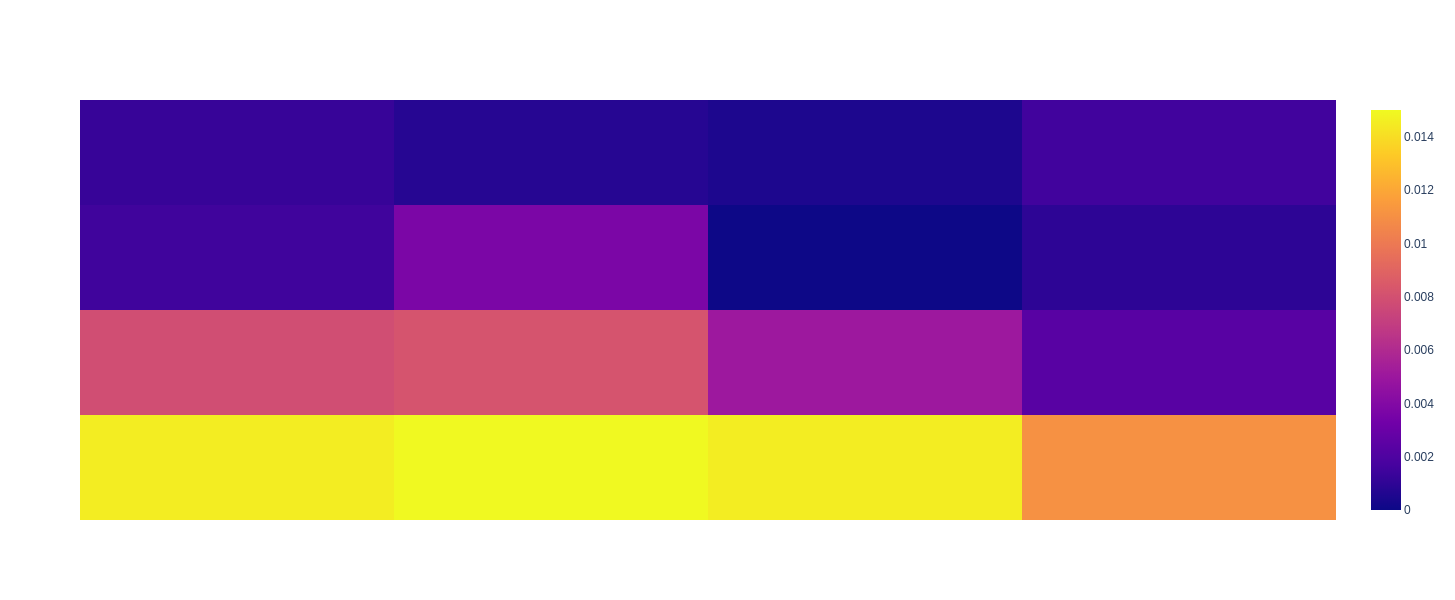

In [227]:
fig = get_dist_fig(dist_matrix)
fig.data[0].update(zmin=0., zmax=0.015) # adjust the color scale
fig.show()